# Libraries

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Download and Extract Dataset

It's necessary to provide a kaggle.json file, which can be obtained at your [user profile](https://www.kaggle.com/settings/account) at Kaggle by clicking on Create New Token. Provide it in the button after running the following code snippet.

In [43]:
from google.colab import files
files.upload() # kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle datasets download mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: creditcard.csv          


## Reading and Preprocessing

In [44]:
# Read .csv
creditcard_df = pd.read_csv('creditcard.csv')
# Remove the "Time" feature (to simplify the dataset a bit)
creditcard_df = creditcard_df.drop('Time', axis=1)
# Scale all features with StandardScaler
classes = creditcard_df['Class']
scaled_data = StandardScaler().fit_transform(creditcard_df.drop('Class', axis=1))
creditcard_df = pd.DataFrame(scaled_data, columns=creditcard_df.drop('Class', axis=1).columns)
creditcard_df['Class'] = classes.reset_index(drop=True)

## Data Analysis

Count of data points with 'Normal' class:  284315
Count of data points with 'Fraud' class:  492


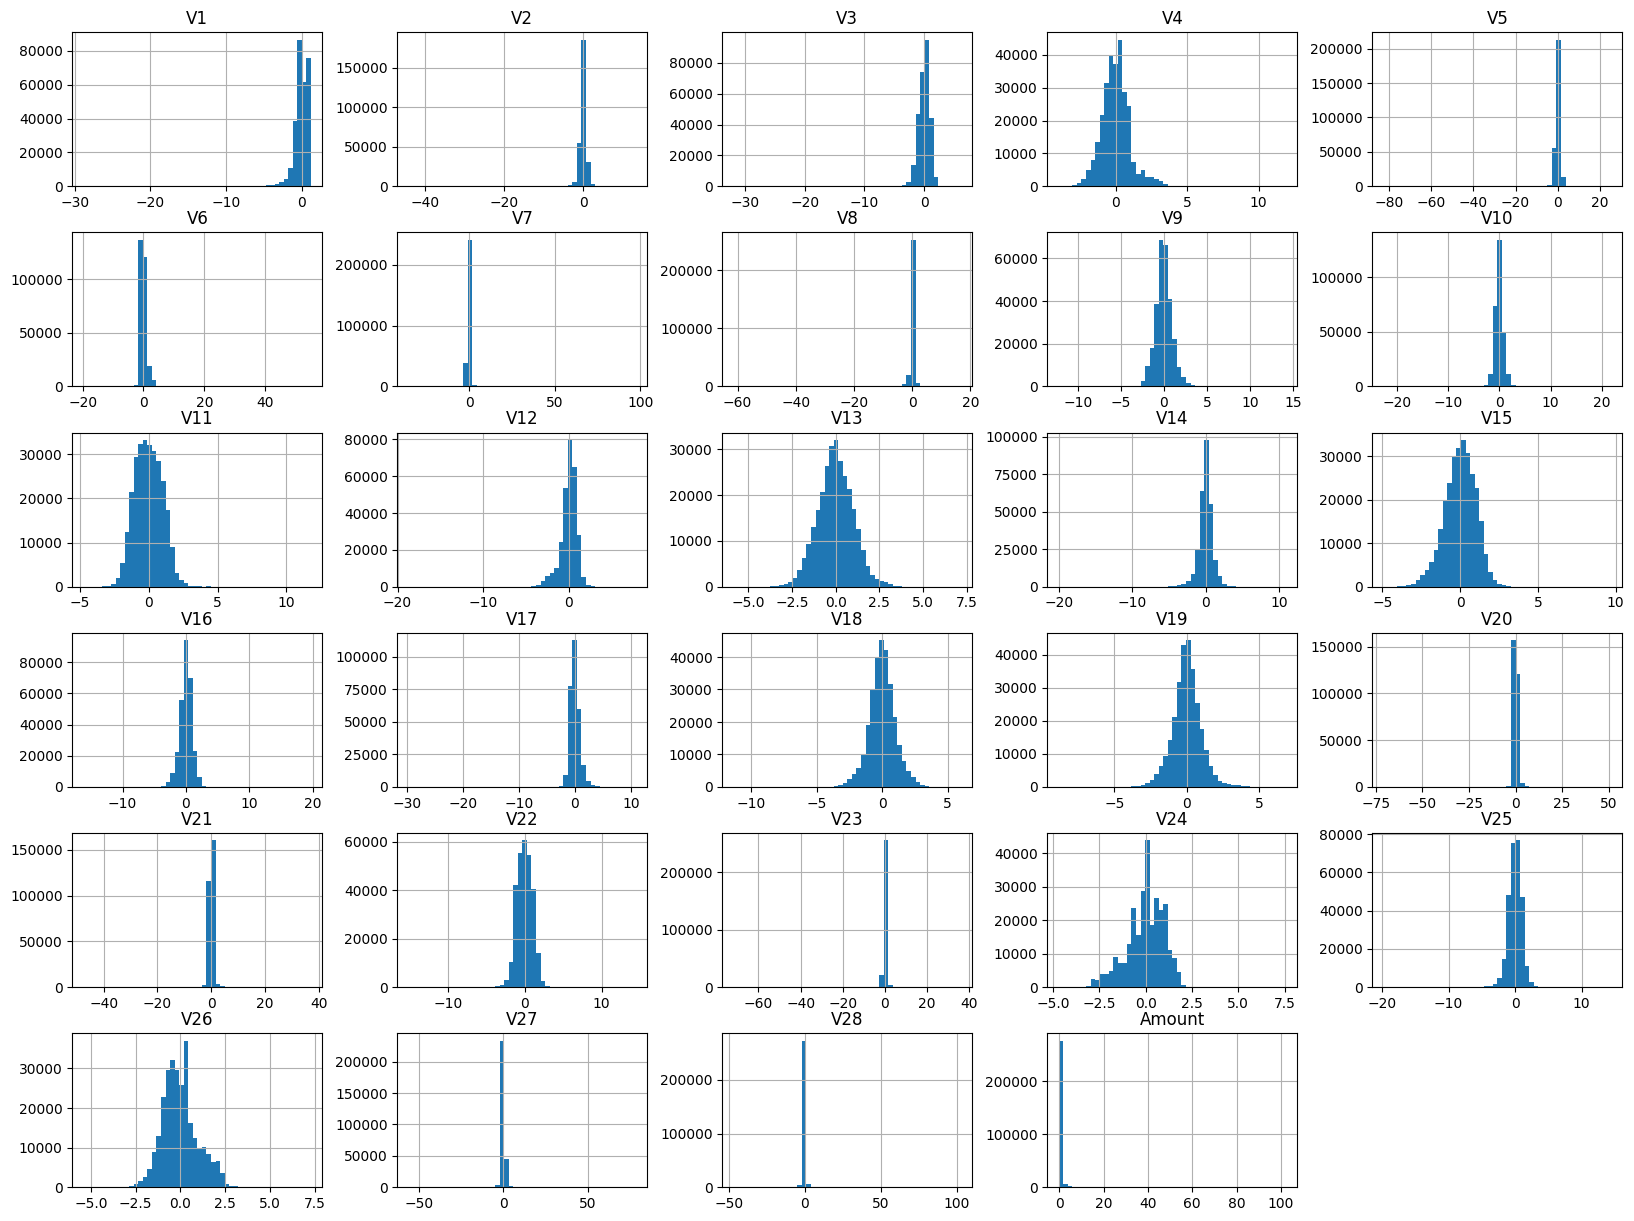

In [45]:
# Histograms of the dataset's features
# Notable: the feature values are following a Gaussian distribution somewhat
print(f"Count of data points with 'Normal' class: ", len(creditcard_df[creditcard_df["Class"] == 0]))
print(f"Count of data points with 'Fraud' class: ", len(creditcard_df[creditcard_df["Class"] == 1]))
hist = creditcard_df.drop('Class', axis=1).hist(bins=50, figsize=(20,15))

# Approach 1: Normal Class Modelling

## Normal Class Data Extraction and Creating the Multivariate Gaussian model

<Figure size 1000x1000 with 0 Axes>

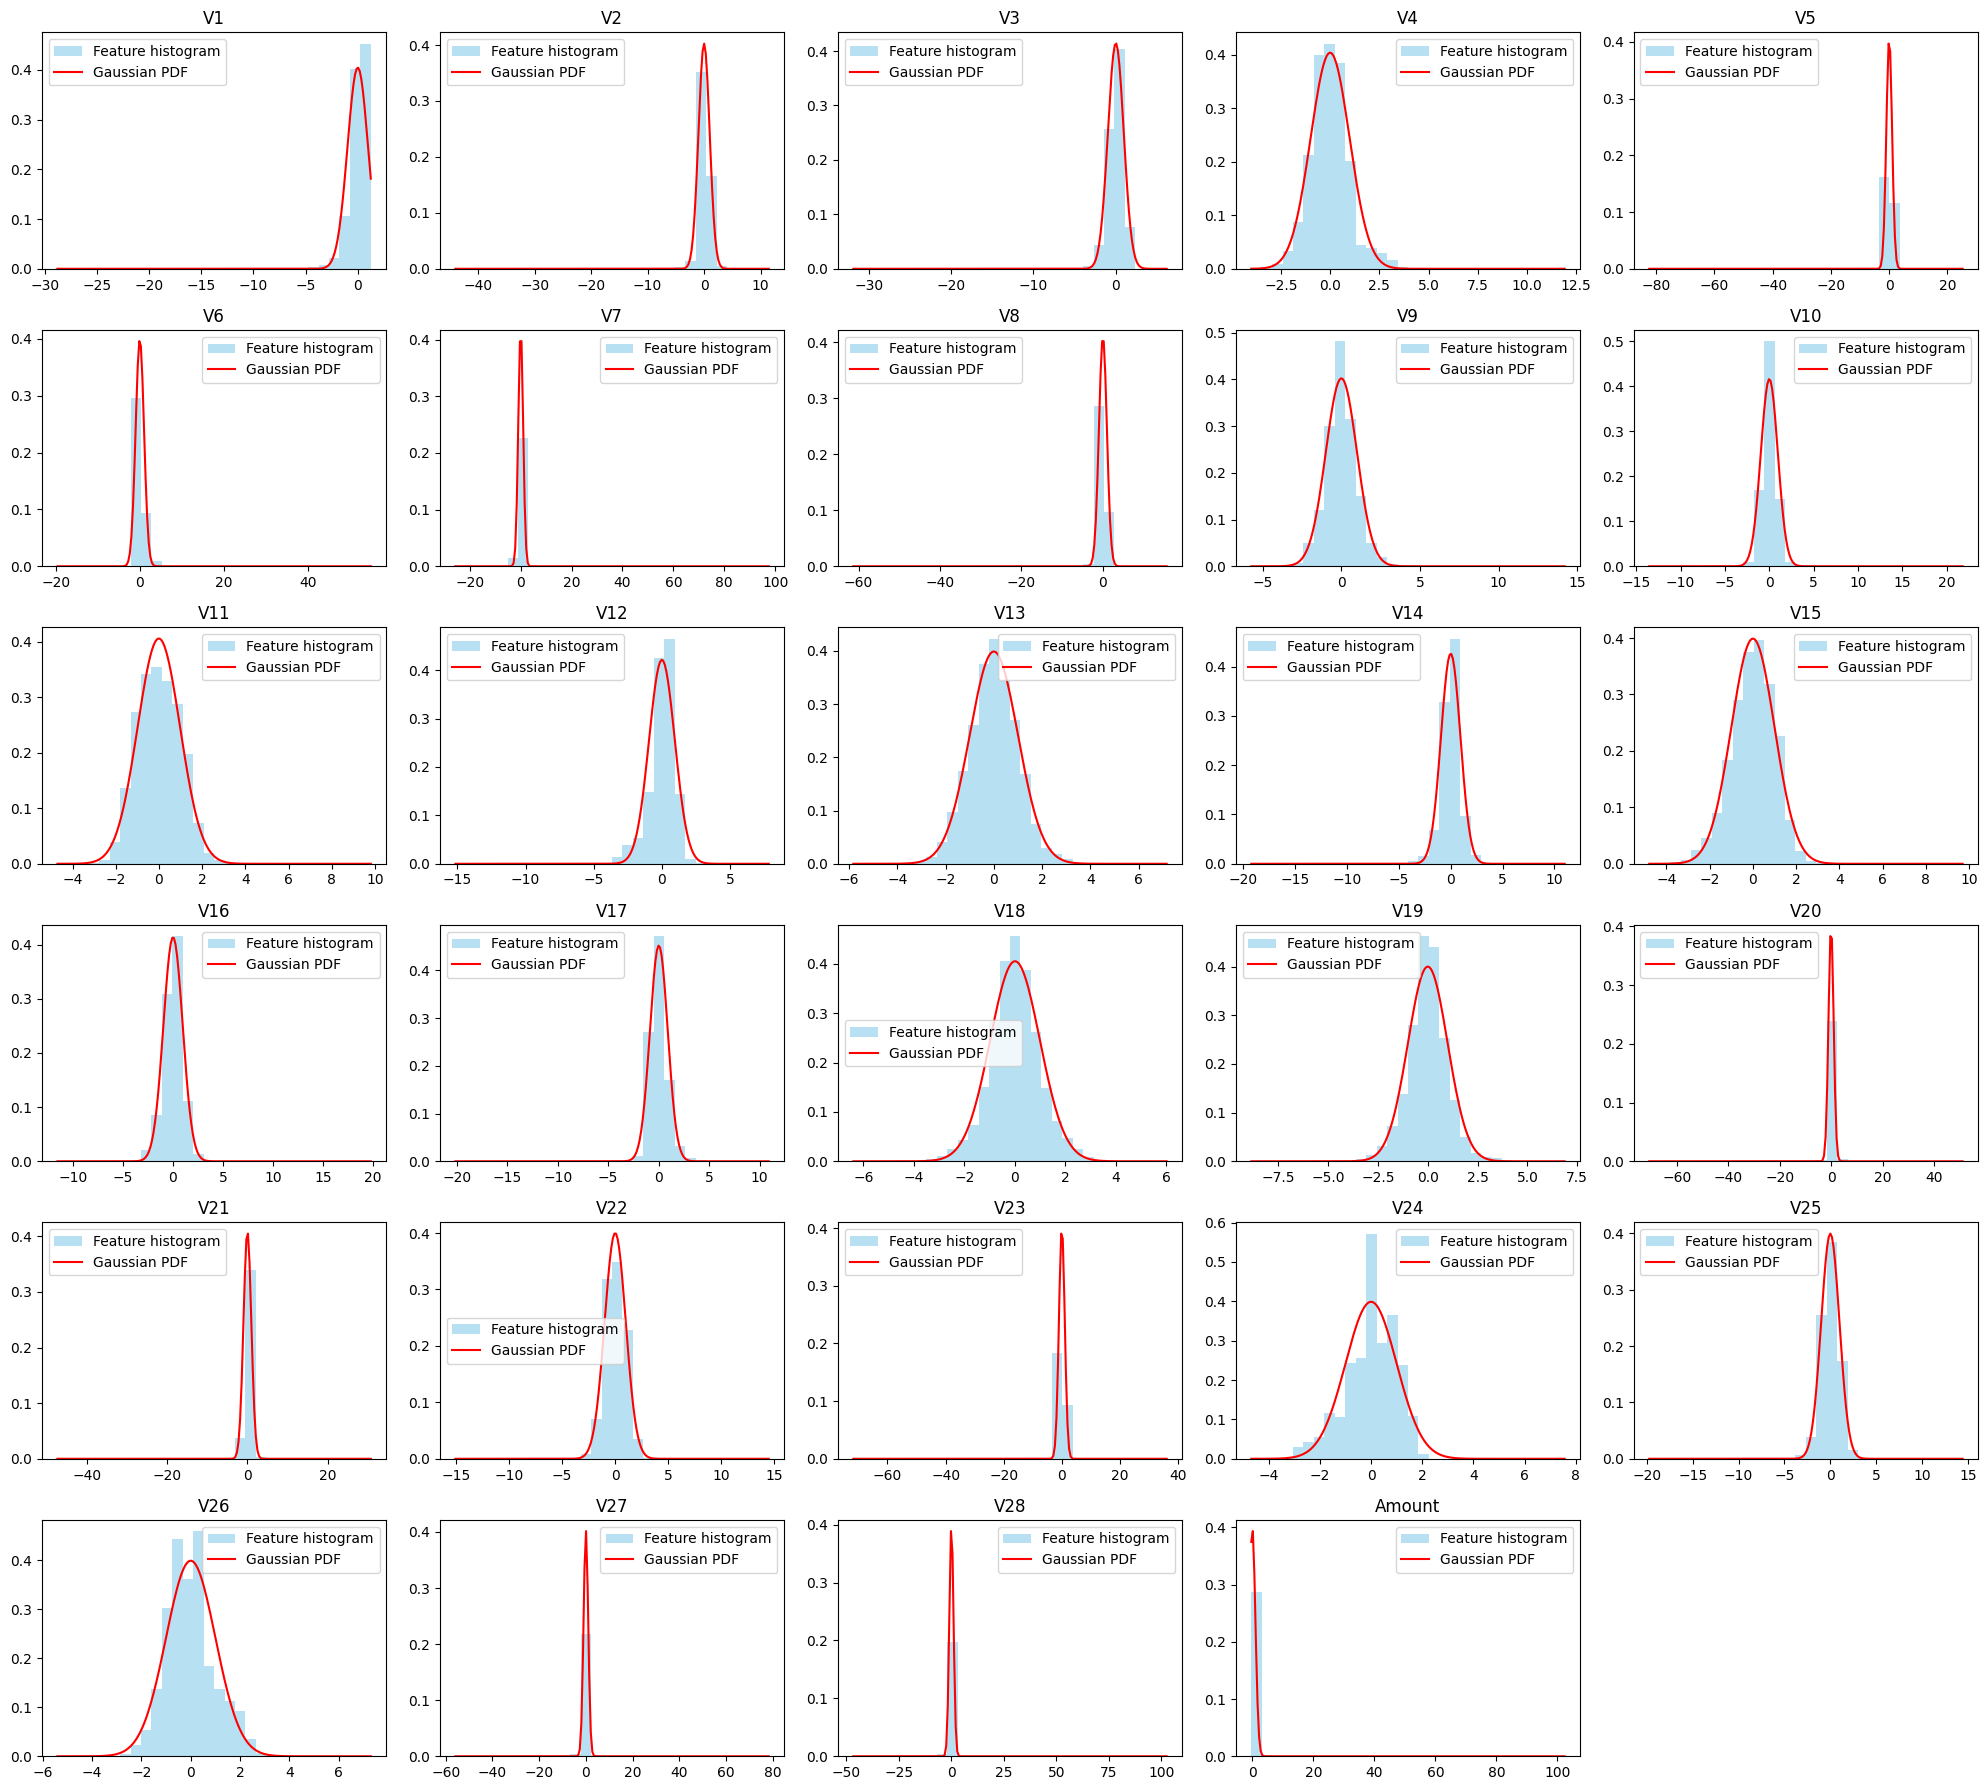

In [46]:
# Non-fraudulent data
nonfraud_df = creditcard_df[creditcard_df["Class"] == 0]
nonfraud_df = nonfraud_df.drop('Class', axis=1) # Dropping because not relevant

# Estimation of the distribution p(x|Cnormal) using Multivariate Gaussian
from scipy.stats import multivariate_normal, norm

gaussian = multivariate_normal(
    mean=nonfraud_df.mean(),
    cov=nonfraud_df.cov(),
    allow_singular=True # Necessary as the covariance matrix isn't SPD (singular positive definite)
)

# Plotting out a visualization of the gaussian over the non-fraudulent data
plt.figure(figsize=(10, 10))
num_features = len(nonfraud_df.columns)
means = gaussian.mean
cov = gaussian.cov
ncols = 5
nrows = int(np.ceil(num_features / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))
axes = axes.flatten()

for i, col in enumerate(nonfraud_df.columns):
    ax = axes[i]
    data = nonfraud_df[col]

    # Histogram
    ax.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', label='Feature histogram')

    # Gaussian function line over it
    x = np.linspace(data.min(), data.max(), 200)
    this_mean = means[i]
    this_cov = np.sqrt(cov[i, i])
    ax.plot(x, norm.pdf(x, this_mean, this_cov), 'r-', label='Gaussian PDF')

    ax.set_title(col)
    ax.legend()

# Remove leftover graphs (in case there is more space in the figure than features to graph)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Calculating Anomaly Scores Through Negative Log Likelihood

Total anomaly score: 11908152.819545124
Anomaly score of Class 0 (normal transactions): 11035695.359361123
Anomaly score of Class 1 (fraudulent transactions): 872457.4601840016
Min anomaly score of Class 0 (normal transactions): 26.45924132245914
Min anomaly score of Class 1 (fraudulent transactions): 29.151951733163546
Max anomaly score of Class 0 (normal transactions): 21278.326758196577
Max anomaly score of Class 1 (fraudulent transactions): 8597.498574444653


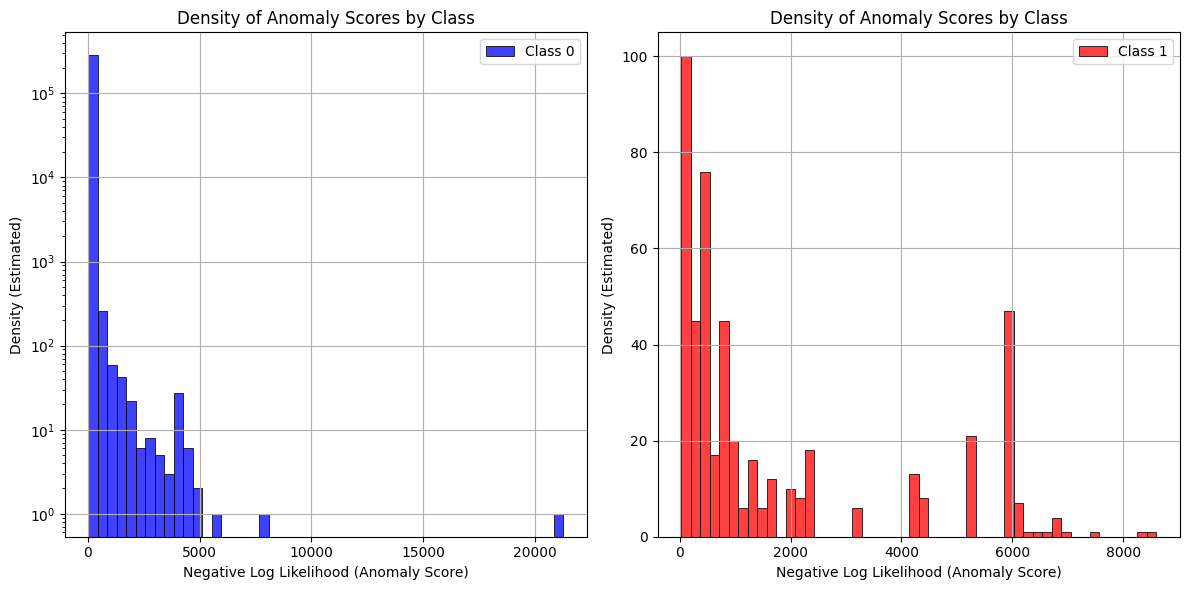

In [47]:
# Anomaly score for all the points using the gaussian from before and negative log likelihood
anomaly_scores = -gaussian.logpdf(creditcard_df.drop('Class', axis=1))

print(f"Total anomaly score: {anomaly_scores.sum()}")
print(f"Anomaly score of Class 0 (normal transactions): {anomaly_scores[creditcard_df['Class'] == 0].sum()}")
print(f"Anomaly score of Class 1 (fraudulent transactions): {anomaly_scores[creditcard_df['Class'] == 1].sum()}")

print(f"Min anomaly score of Class 0 (normal transactions): {anomaly_scores[creditcard_df['Class'] == 0].min()}")
print(f"Min anomaly score of Class 1 (fraudulent transactions): {anomaly_scores[creditcard_df['Class'] == 1].min()}")
print(f"Max anomaly score of Class 0 (normal transactions): {anomaly_scores[creditcard_df['Class'] == 0].max()}")
print(f"Max anomaly score of Class 1 (fraudulent transactions): {anomaly_scores[creditcard_df['Class'] == 1].max()}")

import seaborn as sns
import numpy as np

anomaly_scores = np.array(anomaly_scores)

# Two histograms in separate figures, one for class 0 and another for class 1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(anomaly_scores[creditcard_df['Class'] == 0], kde=False, bins=50, color='blue', label='Class 0')

plt.xlabel("Negative Log Likelihood (Anomaly Score)")
plt.ylabel("Density (Estimated)")
plt.yscale('log')
plt.title("Density of Anomaly Scores by Class")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(anomaly_scores[creditcard_df['Class'] == 1], kde=False, bins=50, color='red', label='Class 1')
plt.xlabel("Negative Log Likelihood (Anomaly Score)")
plt.ylabel("Density (Estimated)")
#plt.yscale('log')
plt.title("Density of Anomaly Scores by Class")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## PR Curve Analysis and F1-Score Optimization

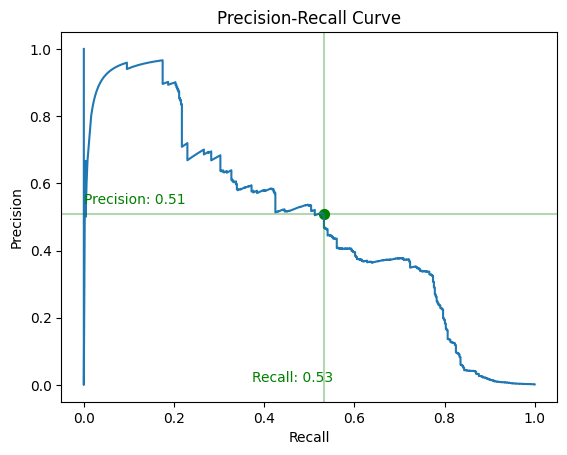

Best Threshold: 692.3891538938624


In [48]:
# Analysis of the F1-Score for the model
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc

# Optimizing using F1 score
# Why? Data is very unbalanced and interweaved, which results in precision and recall by themselves being poor indicators of anomalies
# it is better to make use of the F1 score, since it takes both into consideration.
score_interval = np.linspace(anomaly_scores.min(), anomaly_scores.max(), 500)

precisions, recalls, thresholds = precision_recall_curve(creditcard_df['Class'], anomaly_scores)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx] # Best threshold, selected from the PR curve and f1_score

# PR Curve
plt.plot(recalls, precisions)

# Mark point with best precision/recall trade-off (selected through F1-score optimization)
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]
plt.scatter(best_recall, best_precision, color='green', s=50, label=f"Best F1 score = {f1_scores.max():.2f}")
plt.axhline(y=best_precision, alpha=0.3, color='green')
plt.axvline(x=best_recall, alpha=0.3, color='green')
plt.text(0, best_precision + 0.02, f'Precision: {best_precision:.2f}',
         color='green', ha='left', va='bottom')
plt.text(best_recall + 0.02, 0, f'Recall: {best_recall:.2f}',
         color='green', ha='right', va='bottom')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
#plt.grid(True)
plt.show()
print(f"Best Threshold: {best_threshold}")

## Results

In [49]:
# Final performance results from the selected threshold
final_classes = np.where(anomaly_scores > best_threshold, 1, 0)
print(classification_report(creditcard_df['Class'], final_classes))

print("Confusion Matrix:")
print(confusion_matrix(creditcard_df['Class'], final_classes))

print(f"\nAUC-PR: {auc(recalls, precisions)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.51      0.53      0.52       492

    accuracy                           1.00    284807
   macro avg       0.75      0.76      0.76    284807
weighted avg       1.00      1.00      1.00    284807

Confusion Matrix:
[[284062    253]
 [   231    261]]

AUC-PR: 0.4893912649529517


# Approach 2: Modelling as a Supervised Classification Problem

## Dataset Validation Split and Training the Model

In [50]:
# Separating train, validation and test
# Two splits (since sklearn doesn't have a validation split)
# Split 1: train (50%) and part (50%)
train_df, part_df = train_test_split(creditcard_df, test_size=0.5, random_state=42)

# Split 2: validation (25%) and test (25%) from part
validation_df, test_df = train_test_split(part_df, test_size=0.5, random_state=42)

In [51]:
from sklearn import linear_model

# Logistic Regression
logreg = linear_model.LogisticRegression()
logreg.fit(train_df.drop('Class', axis=1), train_df["Class"])

LogisticRegression()

## Calculating Scores Through Negative Log Likelihood and Analysis

Validation count of Class 0: 71075
Validation count of Class 1: 127


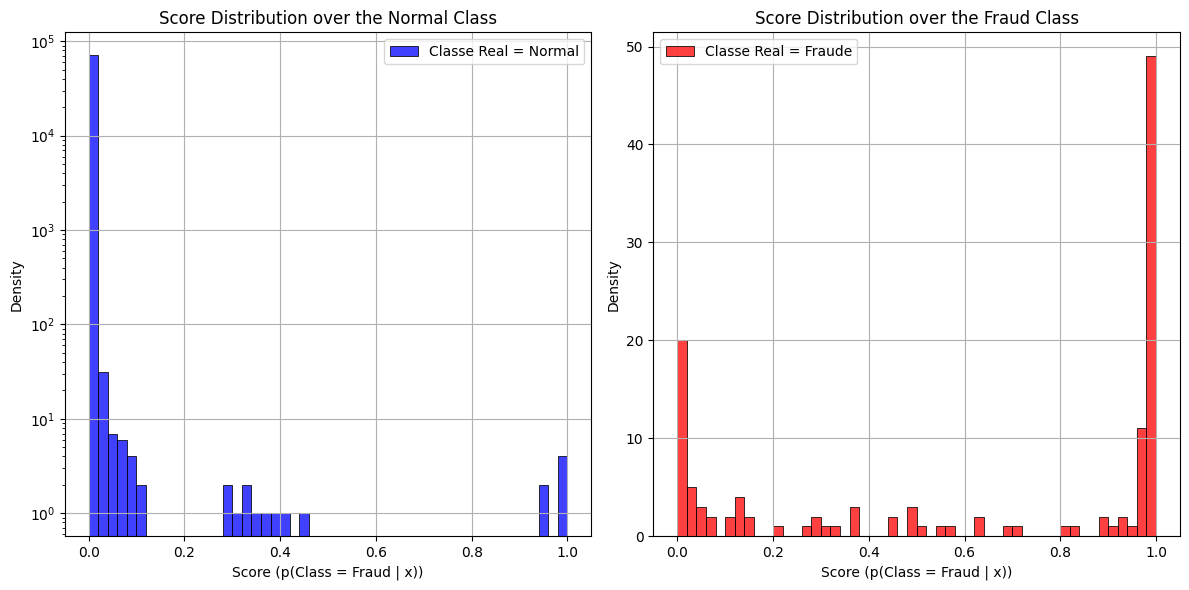

In [52]:
# Scores calculated over validation dataset (we only take the probability of Class 1 (fraud))
scores = logreg.predict_proba(validation_df.drop('Class', axis=1))[:,1]

print(f"Validation count of Class 0: {len(validation_df[validation_df['Class'] == 0])}")
print(f"Validation count of Class 1: {len(validation_df[validation_df['Class'] == 1])}")

#print(f"Score de anomalia média: {scores.mean():.5f}")
#print(f"Score de anomalia mínimo: {scores.min():.5f}")
#print(f"Score de anomalia máximo: {scores.max():.5f}")
#print(f"Mediana dos scores: {np.median(scores):.5f}")

# Plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(scores[validation_df['Class'] == 0], kde=False, bins=50, color='blue', label='Classe Real = Normal')
plt.xlabel("Score (p(Class = Fraud | x))")
plt.ylabel("Density")
plt.yscale('log')
plt.title("Score Distribution over the Normal Class")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(scores[validation_df['Class'] == 1], kde=False, bins=50, color='red', label='Classe Real = Fraude')
plt.xlabel("Score (p(Class = Fraud | x))")
plt.ylabel("Density")
plt.title("Score Distribution over the Fraud Class")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## PR Curve Analysis

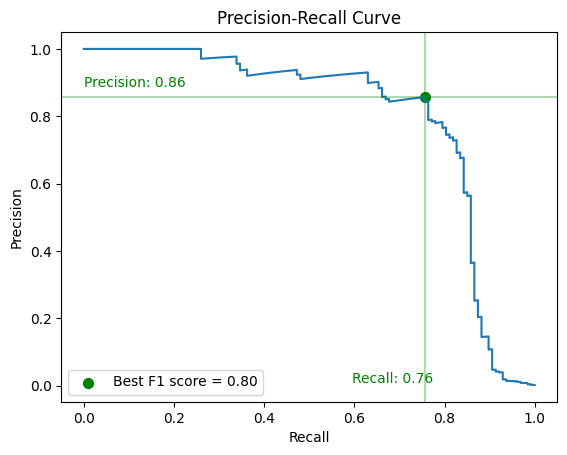

Best Threshold: 0.10961600753296777


In [53]:
# PR Curve Analysis
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(validation_df['Class'], scores)

# F1 Scores
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]

# PR Curve
plt.plot(recalls, precisions)

# Mark the point with the best F1-Score (Best precision/recall trade-off)
plt.scatter(best_recall, best_precision, color='green', s=50, label=f"Best F1 score = {f1_scores.max():.2f}")
plt.axhline(y=best_precision, alpha=0.3, color='green')
plt.axvline(x=best_recall, alpha=0.3, color='green')
plt.text(0, best_precision + 0.02, f'Precision: {best_precision:.2f}',
         color='green', ha='left', va='bottom')
plt.text(best_recall + 0.02, 0, f'Recall: {best_recall:.2f}',
         color='green', ha='right', va='bottom')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
#plt.grid(True)
plt.legend()
plt.show()
print(f"Best Threshold: {best_threshold}")

## Results

In [54]:
final_classes = np.where(logreg.predict_proba(test_df.drop("Class", axis=1))[:,1] > best_threshold, 1, 0)
print(classification_report(test_df['Class'], final_classes))

print("Confusion Matrix:")
print(confusion_matrix(test_df['Class'], final_classes))

from sklearn.metrics import auc
final_rec, final_prec, _ = precision_recall_curve(test_df['Class'], final_classes)
print(f"\nAUC-PR: {auc(final_rec, final_prec)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71083
           1       0.77      0.76      0.76       119

    accuracy                           1.00     71202
   macro avg       0.88      0.88      0.88     71202
weighted avg       1.00      1.00      1.00     71202

Confusion Matrix:
[[71056    27]
 [   29    90]]

AUC-PR: 0.7612989897166482
